In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
databank_dti_csv = '/nfs/masi/gaoc11/GDPR/masi/gaoc11/BRAID/data/dataset_splitting/spreadsheet/databank_dti_v2.csv'
databank_t1w_csv = '/nfs/masi/gaoc11/GDPR/masi/gaoc11/BRAID/data/dataset_splitting/spreadsheet/databank_t1w_v2.csv'

df_dti = pd.read_csv(databank_dti_csv)
df_t1w = pd.read_csv(databank_t1w_csv)

In [3]:
# Merge predictions from model of each fold into one dataframe
prediction_root = '/nfs/masi/gaoc11/projects/BRAID/models/2024-02-07_ResNet101_BRAID_warp/predictions/'
list_prediction_csv = [fn for fn in Path(prediction_root).iterdir() if (fn.suffix == '.csv') and ('predicted_age_fold-' in fn.name)]
list_prediction_csv = sorted(list_prediction_csv)

for csv in list_prediction_csv:
    fold_idx = csv.name.split('fold-')[1].replace('.csv', '')
    
    if fold_idx == '1':
        df_pred = pd.read_csv(csv)
        df_pred = df_pred.rename(columns={'age_pred': f"age_pred_{fold_idx}"})
    else:
        df_tmp = pd.read_csv(csv)
        df_tmp = df_tmp.rename(columns={'age_pred': f"age_pred_{fold_idx}"})
        df_pred = df_pred.merge(df_tmp, on=[
            'dataset','subject','session','scan',
            'sex','race_simple','age','control_label','dataset_subject','age_gt'
        ])

df_pred['age_pred_mean'] = df_pred[['age_pred_1', 'age_pred_2', 'age_pred_3', 'age_pred_4', 'age_pred_5']].mean(axis=1)

In [4]:
# Remove rows with extreme values
df_pred = df_pred.loc[(df_pred['age_pred_mean']>=35)&
                      (df_pred['age_pred_mean']<100),].copy()

In [5]:
# Retrieve diagnosis information
df_pred['diagnosis'] = None
for i, row in df_pred.iterrows():
    values = df_dti.loc[
        (df_dti['dataset']==row['dataset'])&
        (df_dti['subject']==row['subject'])&
        (df_dti['session']==row['session']),
        'diagnosis_simple'].values
    values = values[~pd.isna(values)]
    try:
        dx = values[0]
    except:
        dx = None
    df_pred.at[i, 'diagnosis'] = dx
    
df_pred = df_pred.loc[(df_pred['age_gt']>=45)&(df_pred['age_gt']<90)]

Find matched age distribution with seed: 7, age_gt_mean: {'normal': 70.72530263264974, 'MCI': 70.75696650187174, 'dementia': 70.69342636108398}


<Axes: xlabel='diagnosis', ylabel='BAG'>

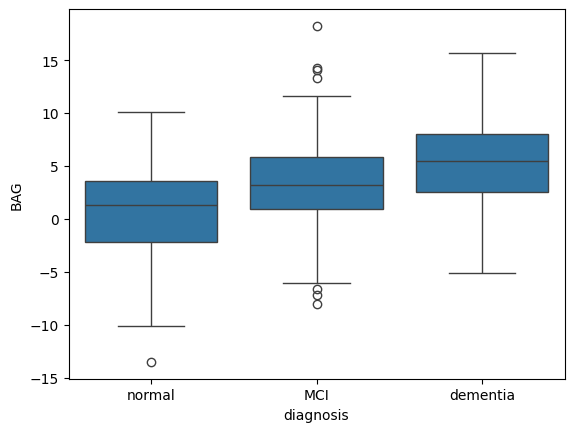

In [6]:
# Sample subjects for each diagnosis group
num_subj = 150
age_min = 65
age_max = 75
datasets = ['NACC', 'OASIS4', 'BLSA', 'OASIS3', 'ADNI']

for seed in range(100):
    np.random.seed(seed)

    subjects = {'normal': None, 'MCI': None, 'dementia': None}

    filter = (df_pred['age_gt']>=age_min) & (df_pred['age_gt']<age_max) & (df_pred['dataset'].isin(datasets))


    candidates = df_pred.loc[filter & (df_pred['diagnosis']=='dementia'), 'dataset_subject'].unique()
    subjects['dementia'] = np.random.choice(candidates, num_subj, replace=False)


    candidates = []
    for dataset_subject in df_pred.loc[filter & (df_pred['diagnosis']=='MCI'), 'dataset_subject'].unique():
        if 'dementia' in df_pred.loc[df_pred['dataset_subject']==dataset_subject, 'diagnosis'].values:
            continue
        else:
            candidates.append(dataset_subject)
    candidates = np.array(candidates)
    subjects['MCI'] = np.random.choice(candidates, num_subj, replace=False)


    candidates = []
    for dataset_subject in df_pred.loc[filter & (df_pred['diagnosis']=='normal'), 'dataset_subject'].unique():
        if 'dementia' in df_pred.loc[df_pred['dataset_subject']==dataset_subject, 'diagnosis'].values:
            continue
        if 'MCI' in df_pred.loc[df_pred['dataset_subject']==dataset_subject, 'diagnosis'].values:
            continue
        else:
            candidates.append(dataset_subject)
    candidates = np.array(candidates)
    subjects['normal'] = np.random.choice(candidates, num_subj, replace=False)


    df = pd.DataFrame()
    age_gt_mean = {}
    
    for group in subjects.keys():
        df_tmp = df_pred.loc[filter & df_pred['dataset_subject'].isin(subjects[group]) & (df_pred['diagnosis']==group)].copy()
        df_tmp = df_tmp.groupby('dataset_subject').sample(n=1, random_state=seed)
        assert len(df_tmp['dataset_subject'].unique()) == num_subj
        df = pd.concat([df, df_tmp], axis=0)
        age_gt_mean[group] = df_tmp['age_gt'].mean()
        
    # we want the three group have similar age_gt distribution for fair comparison
    if np.abs(age_gt_mean['normal'] - age_gt_mean['MCI']) < 0.05 and np.abs(age_gt_mean['normal'] - age_gt_mean['dementia']) < 0.05:
        print(f'Find matched age distribution with seed: {seed}, age_gt_mean: {age_gt_mean}')
        break

df['BAG'] = df['age_pred_mean'] - df['age_gt']
sns.boxplot(data=df, x='diagnosis', y='BAG')

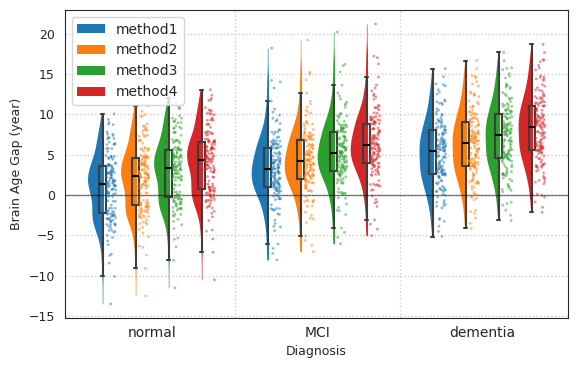

In [29]:
# Optimize raincloud plot parameters, eventually, we will compare four methods, so we need num_hue = 4
# assume we already finished all training and model inference, and we have predicted age from all four methods
df_four = pd.DataFrame()
for i, method in enumerate(['method1', 'method2', 'method3', 'method4']):
    df_tmp = df.copy()
    df_tmp['method'] = method
    df_tmp['BAG'] += i  # for sanity check
    df_four = pd.concat([df_four, df_tmp], axis=0)



diagnosis_x_center = {'normal': 1.5, 'MCI': 4.5, 'dementia': 7.5}
df_four['x_axis'] = df_four['diagnosis'].map(diagnosis_x_center)
method_shift = {'method1': -0.9, 'method2': -0.3, 'method3': 0.3, 'method4': 0.9}
df_four['x_axis'] = df_four.apply(lambda row: row['x_axis'] + method_shift[row['method']], axis=1)

fig_width = 6.5
fig_height = 4
dpi = 300
font_size = 9
violin_width = 1
jitter = 0.15 # strip plot
alpha_scatter = 0.5
sns.set_style('white')

sns.color_palette("husl", 4)

fig, ax = plt.subplots(1, 1, figsize=(fig_width,fig_height))

# Violin plot
ax = sns.violinplot(
    data = df_four,
    x = 'x_axis',
    y = 'BAG',
    hue = 'method',
    cut=0,
    width=violin_width,
    inner=None,
    ax=ax,
    saturation=1,
    linewidth=0,
    native_scale=True,
    )

# Clip the right half of each violin.
for item in ax.collections:
    x0, y0, width, height = item.get_paths()[0].get_extents().bounds
    item.set_clip_path(plt.Rectangle((x0, y0), width/2, height, transform=ax.transData))
    
# Create strip plots with partially transparent points of different colors depending on the group.
num_items = len(ax.collections)
ax = sns.stripplot(
    data = df_four,
    x='x_axis',
    y= 'BAG',
    hue='method',
    jitter=jitter,
    alpha=alpha_scatter,
    size=2,
    ax=ax,
    legend=False,
    native_scale=True
    )

# Shift each strip plot strictly below the correponding volin.
for item in ax.collections[num_items:]:
    item.set_offsets(item.get_offsets() + (jitter,0))

# Create narrow boxplots on top of the corresponding violin and strip plots, with thick lines, the mean values, without the outliers.
ax = sns.boxplot(
    data = df_four,
    x='x_axis',
    y='BAG',
    width=violin_width*0.2,
    # linecolor='tab:gray',
    showfliers=False,
    boxprops=dict(facecolor=(0,0,0,0),
                linewidth=1.5, zorder=2),
    whiskerprops=dict(linewidth=1.5),
    capprops=dict(linewidth=1.5),
    medianprops=dict(linewidth=1.5, color='black'),
    ax=ax,
    native_scale=True)    

# Horizontal line at 0
ax.axhline(y=0, linestyle='-',linewidth=1, color = 'black', alpha=0.5)
ax.set_xticks([1.5, 4.5, 7.5], minor=True)
ax.set_xticklabels(['normal', 'MCI', 'dementia'], minor=True)
ax.set_xticks([3, 6], minor=False)
ax.set_xticklabels(['', ''], minor=False)

ax.grid(linestyle=':', linewidth=1, which='major')

ax.set_xlabel('Diagnosis', fontsize=font_size)
ax.set_ylabel('Brain Age Gap (year)', fontsize=font_size)
ax.tick_params(labelsize=font_size)